In [7]:
import numpy as np
import cv2 as cv
import glob
import matplotlib.pyplot as plt

In [25]:
CELL_LENGTH = 21.34
ROWS = 9
COLS = 6

manual_corners = []

In [10]:
def click_event(event, x, y, flags, params):
    global manual_corners
    if event == cv.EVENT_LBUTTONDOWN:
        print(x, ' ', y)
        manual_corners.append([x, y])
        font = cv.FONT_HERSHEY_SIMPLEX
        strXY = str(x) + ', ' + str(y)
        cv.putText(img, strXY, (x, y), font, .5, (255, 255, 0), 2)
        cv.imshow('image', img)

In [40]:
def get_corners_manually(img):
    print("Click on the four corners of the chessboard in the following order: bottom left, top left, top right, bottom right. When done, press any key to continue.")
    global manual_corners, ROWS, COLS
    #In case the text and text-color messes with the corner interpolation
    
    visual_image = img.copy()
    cv.imshow('image', visual_image)
    cv.setMouseCallback('image', click_event)
    cv.waitKey(0)
    cv.destroyAllWindows()
    cv.imshow('image', visual_image)
    if len(manual_corners) != 4:
        print("The number of corners is not 4. Please try again.")
        manual_corners = []
        return get_corners_manually(img)
    cv.destroyAllWindows()
    corners = interpolate_chessboard_corners(manual_corners, ROWS, COLS)
    #print(corners)
    manual_corners = []
    # draw the corners on the image
    #for corner in corners:
    #   cv.circle(img, (int(corner[0]), int(corner[1])), 5, (0, 0, 255), -1)

    #cv.imshow("Image", img)
    cv.waitKey(0)
    cv.destroyAllWindows()
    return corners

In [12]:
def draw_world_axis(rVecs, tVecs, cameraMatrix, d, img):
    #Create array that will hold four 3D points
    size = 1
    points = np.float32([[0,0,0],[size * CELL_LENGTH,0,0],[0,size * CELL_LENGTH,0],[0,0,size * CELL_LENGTH]])
                                                                                                                                        #^might have to be negative
    #Project 3D points to 2D image
    imagePoints = cv.projectPoints(points, rVecs, tVecs, cameraMatrix, d)
    #To do: think of better way to do this conversion
    pointOne = imagePoints[0][0][0]
    pointOne = (int(pointOne[0]),int(pointOne[1]))

    pointTwo = imagePoints[0][1][0]
    pointTwo = (int(pointTwo[0]),int(pointTwo[1]))

    pointThree = imagePoints[0][2][0]
    pointThree = (int(pointThree[0]),int(pointThree[1]))

    pointFour = imagePoints[0][3][0]
    pointFour = (int(pointFour[0]),int(pointFour[1]))
	#DRAWING
	#Draws XYZ lines in different colors and thickness of lines
    cv.line(img, pointOne, pointTwo, (255, 0, 0), 3)
    cv.line(img, pointOne, pointThree, (0, 255, 0), 3)
    cv.line(img, pointOne, pointFour, (0, 0, 255), 3)
    return img

In [38]:
def interpolate_chessboard_corners(corners, rows, cols):
    #Defining corner order
    tl, tr, br, bl = corners
    #Transforming the corner array into the type the function getPerspective has
    points = np.zeros((4, 2), dtype = "float32")
    points[0] = tl
    points[1] = tr
    points[2] = br
    points[3] = bl

    #Calculating width and heigth of the image inside the boundary of the 4 corners
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    #mapping 4 new corners from the new heigth and width
    dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
    
    #linearly expanding all the points
    x_coord = np.linspace(dst[0][0], dst[1][0], rows)
    y_coord = np.linspace(dst[0][1], dst[3][1], cols)

    #making a holder array that holds all points
    rect = np.zeros((rows*cols, 2), dtype = "float32")
    counter = 0
    for j in range(cols):
        for k in range(rows):
            rect[counter] = [x_coord[k],y_coord[j]]
            counter += 1
    #Compute perspective transform from unwarped points to warped points
    M = cv.getPerspectiveTransform(dst, points)

    # Apply the transformation matrix to the array of all points
    transformed_points = cv.perspectiveTransform(rect.reshape(-1,1,2), M)
    return transformed_points

In [39]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((COLS * ROWS, 3), np.float32)
objp[:,:2] = np.mgrid[0:ROWS,0:COLS].T.reshape(-1,2) * CELL_LENGTH
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
# read images from folder relative to the main.py file
images = glob.glob('images/*.jpg')
print(len(images))
img_counter = 0
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (ROWS, COLS), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (ROWS, COLS), corners2, ret)
        #plt.figure(figsize = (20,15))
        # plt.imshow(img)
        # plt.show()
        # cv.imshow('img', img)
        # cv.waitKey(0)
    else:
        manual_corners = get_corners_manually(img)
        #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, manual_corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (ROWS, COLS), corners2, True)
        plt.figure(figsize = (20,15))
        cv.imshow('img', img)
        cv.waitKey(0)
    cv.destroyAllWindows()

    img_counter += 1
    print(img_counter)

22
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
Click on the four corners of the chessboard in the following order: bottom left, top left, top right, bottom right. When done, press any key to continue.
695   600


AttributeError: 'numpy.ndarray' object has no attribute 'append'

The number of corners is not 4. Please try again.
Click on the four corners of the chessboard in the following order: bottom left, top left, top right, bottom right. When done, press any key to continue.
693   602
604   313
1029   309
1394   573
22


<Figure size 2000x1500 with 0 Axes>

In [ ]:
# cv.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img = cv.imread('ass1/images/00.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
# undistort
mapx, mapy = cv.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
ret,rvecs, tvecs = cv.solvePnP(objpoints[0], imgpoints[0], mtx, dist)
img = draw_world_axis(rvecs,tvecs,mtx,dist,img)
cv.imwrite('calibresult.png', img)

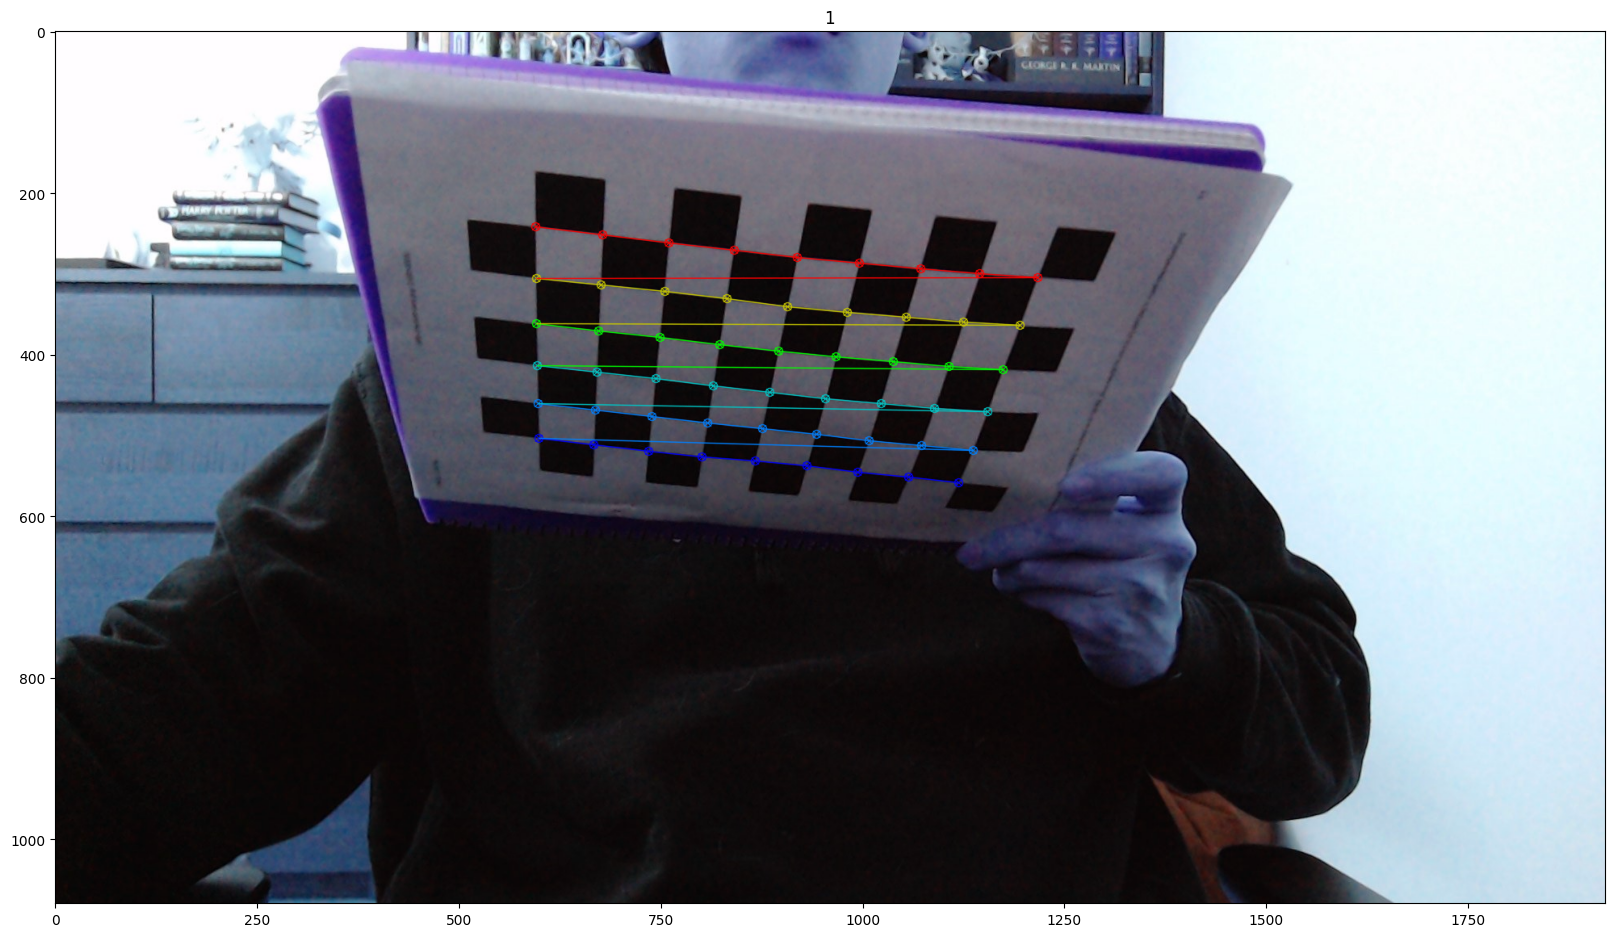

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img):
    """Preprocesses the image. This includes converting it to grayscale, thresholding it, dilating it and sharpening the edges.

    Parameters
    ----------
    img : np.ndarray
        The image to preprocess.

    Returns
    -------
    img : np.ndarray
        The preprocessed image.
    """
    CRITERIA = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, corners = cv.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        corners = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), CRITERIA)
        cv.drawChessboardCorners(img, (9, 6), corners, ret)
    return img

img = cv.imread("images/dark.jpg")
img = preprocess_image(img)
# show the images in a 2x2 grid and set titles
plt.figure(figsize = (20,15))
plt.title('1')
plt.imshow(img, cmap = 'gray')



In [15]:
import glob
import os
from config import Config
from pathlib import Path

config = Config()
config.load()

# read ass1/images and rename them all to 00.jpg, 01.jpg, 02.jpg, etc.
# this is to make it easier to read them in the next step
images = glob.glob(config.get("calibration", "image_path") + '*.jpg')
config.get("calibration", "image_path")
len(images)

5